In [14]:
# import settings and functions
%run ./../../imports.ipynb


Imports finished! :D


## What mesh?

Copy your choice to the next cell

for SquareTop:
```
analytical_solution_tag = "-ana_square_top"
generate_config = generateConfig_squareTop
generate_mesh = generateMesh_squareTop
```

for SquareSinCos:
```
analytical_solution_tag = "-ana_square_sincos"
generate_config = generateConfig_squareSinCos
generate_mesh = generateMesh_squareSinCos
```

In [15]:
# Change according to instruction above
analytical_solution_tag = "-ana_square_sincos"
generate_config = generateConfig_squareSinCos
generate_mesh = generateMesh_squareSinCos

## Analysis setup

In [16]:
# Convergence analysis parameters
order_list = [1, 2, 3, 4] # approximation order p
elem_size_list = [0.2, 0.1, 0.05, 0.02, 0.01] # element size h
# elem_size_list = [0.5, 0.2, 0.1] # element size h
params.triangle_mesh = True

ana_name = "ana_square_top"
sumanalys = "FEM_errors.csv"

run_test = True
run_analysis = False

naming = ["order", "gaussnum", "iterations","volume", "datanum","rmsPoiErr", "errorIndicator",
          "L2norm", "H1seminorm","fluxErr", "orderRefinementCounter"]

error_name_list = ["L2norm", "H1seminorm", "fluxErr"]
error_label_list = [(r'Global error $L^2$-norm'),
               (r'Global error $H^1$-seminorm'), (r'Global Flux error')]

In [17]:
params.conductivity = 1.0 # linear conductivity
params.element_size = 0.1 # element size in the regular mesh
params.order = 1 # approximation order for displacements

# params.triangle_mesh = False # use triangular mesh

# Pre-processing parameters
params.mesh_file = "square_top"
params.length_x = 1
params.length_y = 1
params.length_z = 0
params.show_mesh = True


# solution parameters
params.log_file = "log" # log file name 
params.nproc = 1 # number of processors


## Run test

In [18]:
# start display for showing results
display = Display(backend="xvfb", visible=False, size=(1024, 768))
display.start()

[SET_ATTR_FLUX_SQUARE_SINCOS]
number_of_attributes=1
user1=1.0
 
[SET_ATTR_PRESSURE_SQUARE_SINCOS]
number_of_attributes=1
user1=1.0
 
[SET_ATTR_SOURCE_SQUARE_SINCOS]
number_of_attributes=1
user1=1.0
 


Read "square_top.h5m"
Wrote "square_top.vtk"


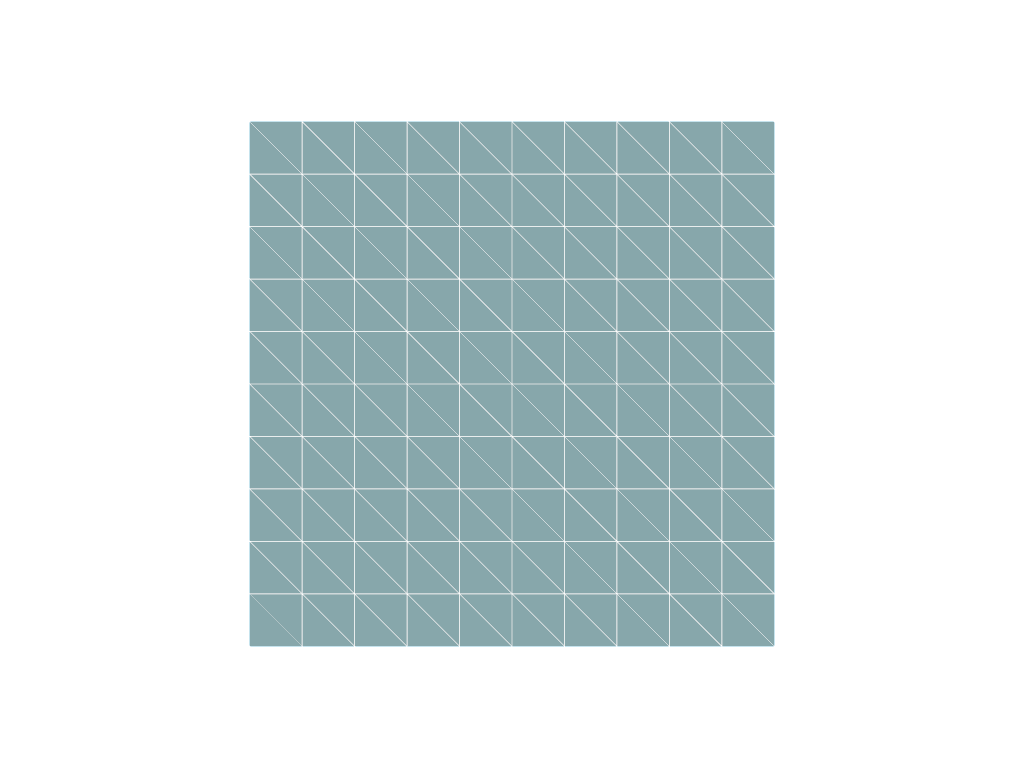

In [19]:
# Testing mesh generation
if run_test:
    params.show_mesh = True
    generate_config(params)
    generate_mesh(params)

In [20]:
# Testing running analysis
if run_test:
    params.part_file = params.mesh_file + "_" + str(params.nproc) + "p.h5m"
    !{mofem_part} -my_file {params.mesh_file + ".h5m"} -my_nparts {params.nproc} -output_file {params.part_file} -dim 2 -adj_dim 1
    !{classic_diffusion} -file_name {params.part_file} -my_order {params.order} {analytical_solution_tag}

    !convert.py out*


[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 96d249a88a9080b60813626713aa8ef8e136ef2a
[0] <inform> Local time: 2024-2-29 22:25:15
[0] <inform> UTC time: 2024-2-29 22:25:15
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316737 type BLOCKSET UNKNOWNNAME msId 1 name untitled
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 2 name FLUX_SQUARE_SINCOS             
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316739 type BLOCKSET UNKNOWNNAME msId 3 name PRESSURE_SQUARE_SINCOS         
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316740 type BLOCKSET UNKNOWNNAME msId 4 name SOURCE_SQUARE_SINCOS           
[0] <inform> [mofem_part] meshset 12682136550675316737 type BLOCKSET UNKNOWNNAME msId 1 name untitled
[0] <inform> [mofem_part] meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 2 name FLU

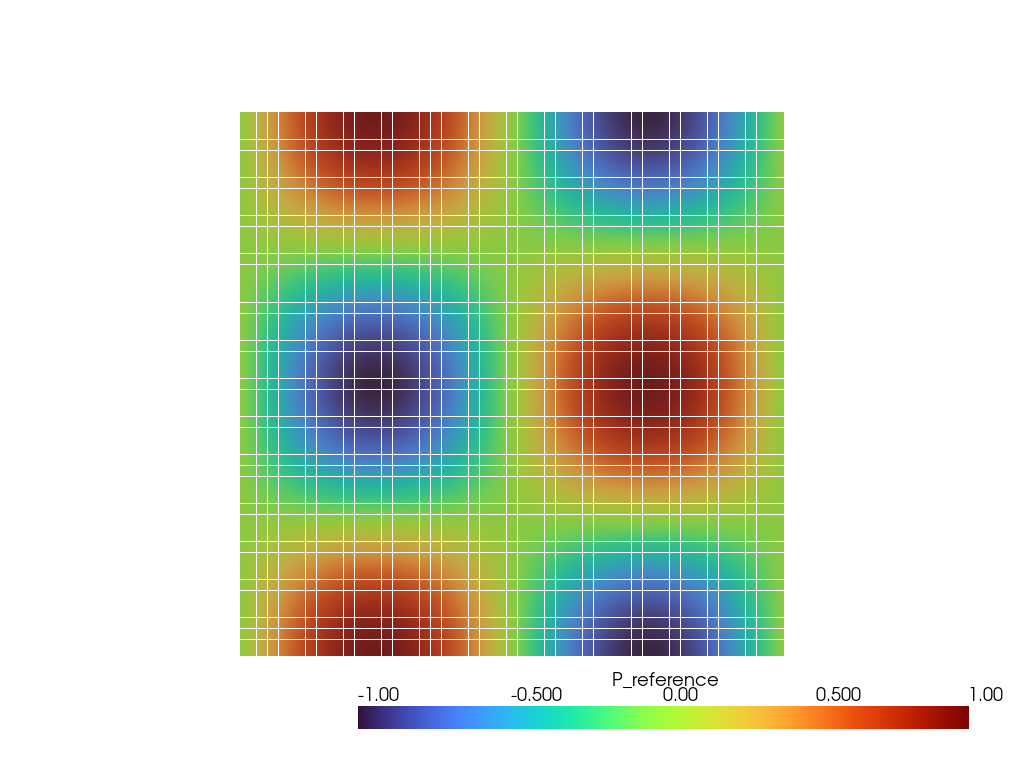

In [21]:
if run_test:
    params.show_file = "out_ori_result"
    params.show_field = "P_reference"
    params.show_edges = True
    show_results(params)

## Convergence analysis

In [22]:
if run_analysis:
    !rm {sumanalys}
    !rm ./output_files/out*
    for elem_size in elem_size_list:
        params.element_size = elem_size
        params.show_mesh = False
        generate_mesh(params)
        params.part_file = params.mesh_file + "_" + str(params.nproc) + "p.h5m"
        !{mofem_part} -my_file {params.mesh_file + ".h5m"} -my_nparts {params.nproc} -output_file {params.part_file} -dim 2 -adj_dim 1
        for order in order_list:
            params.order = order
            !{classic_diffusion} -file_name {params.part_file} -my_order {params.order} {analytical_solution_tag}
    !mv {sumanalys} {ana_name}.csv


## Read and organise results

In [23]:
# read analysis results from ana_name
analysis = []
data = pd.read_csv(ana_name+'.csv', header=None,
                   names=naming,  index_col=False)
analysis.append(data)
analysis[0] = data

In [24]:
# separate by order
classic = []

for i in order_list:
    classic.append(analysis[0].query('order == ' + str(i)))

## Plot results

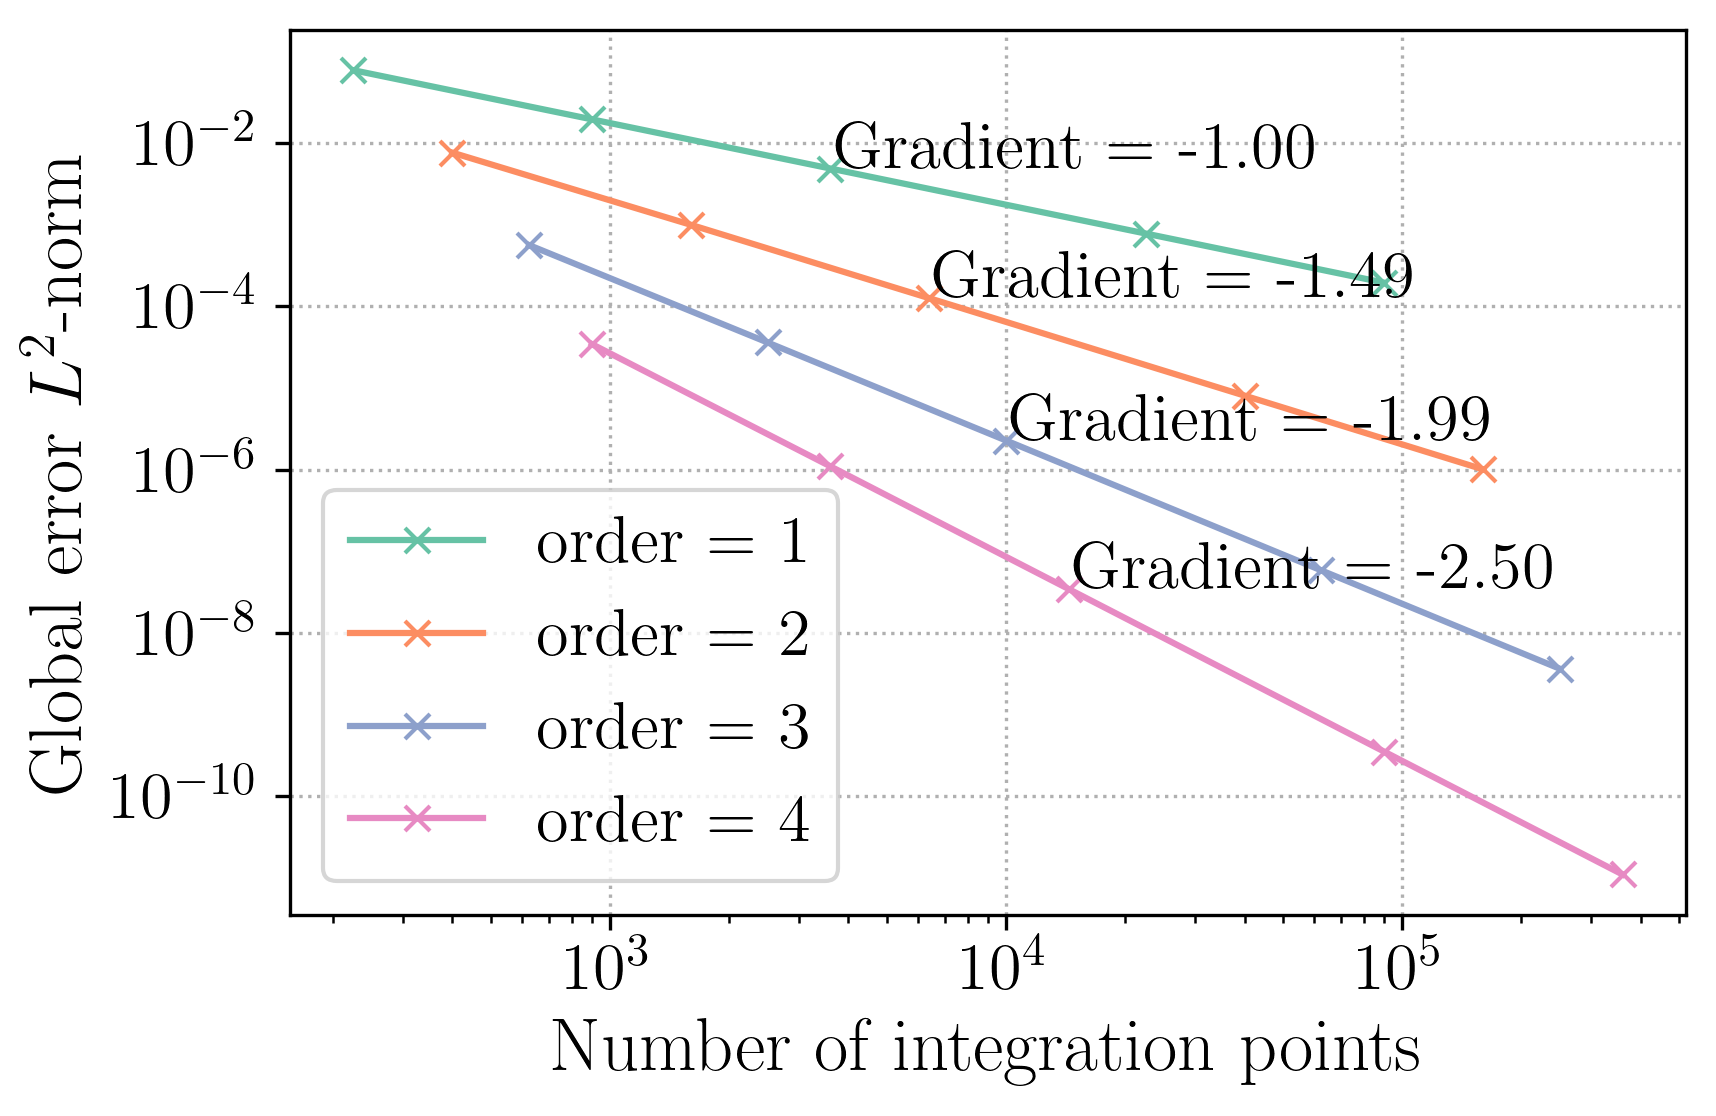

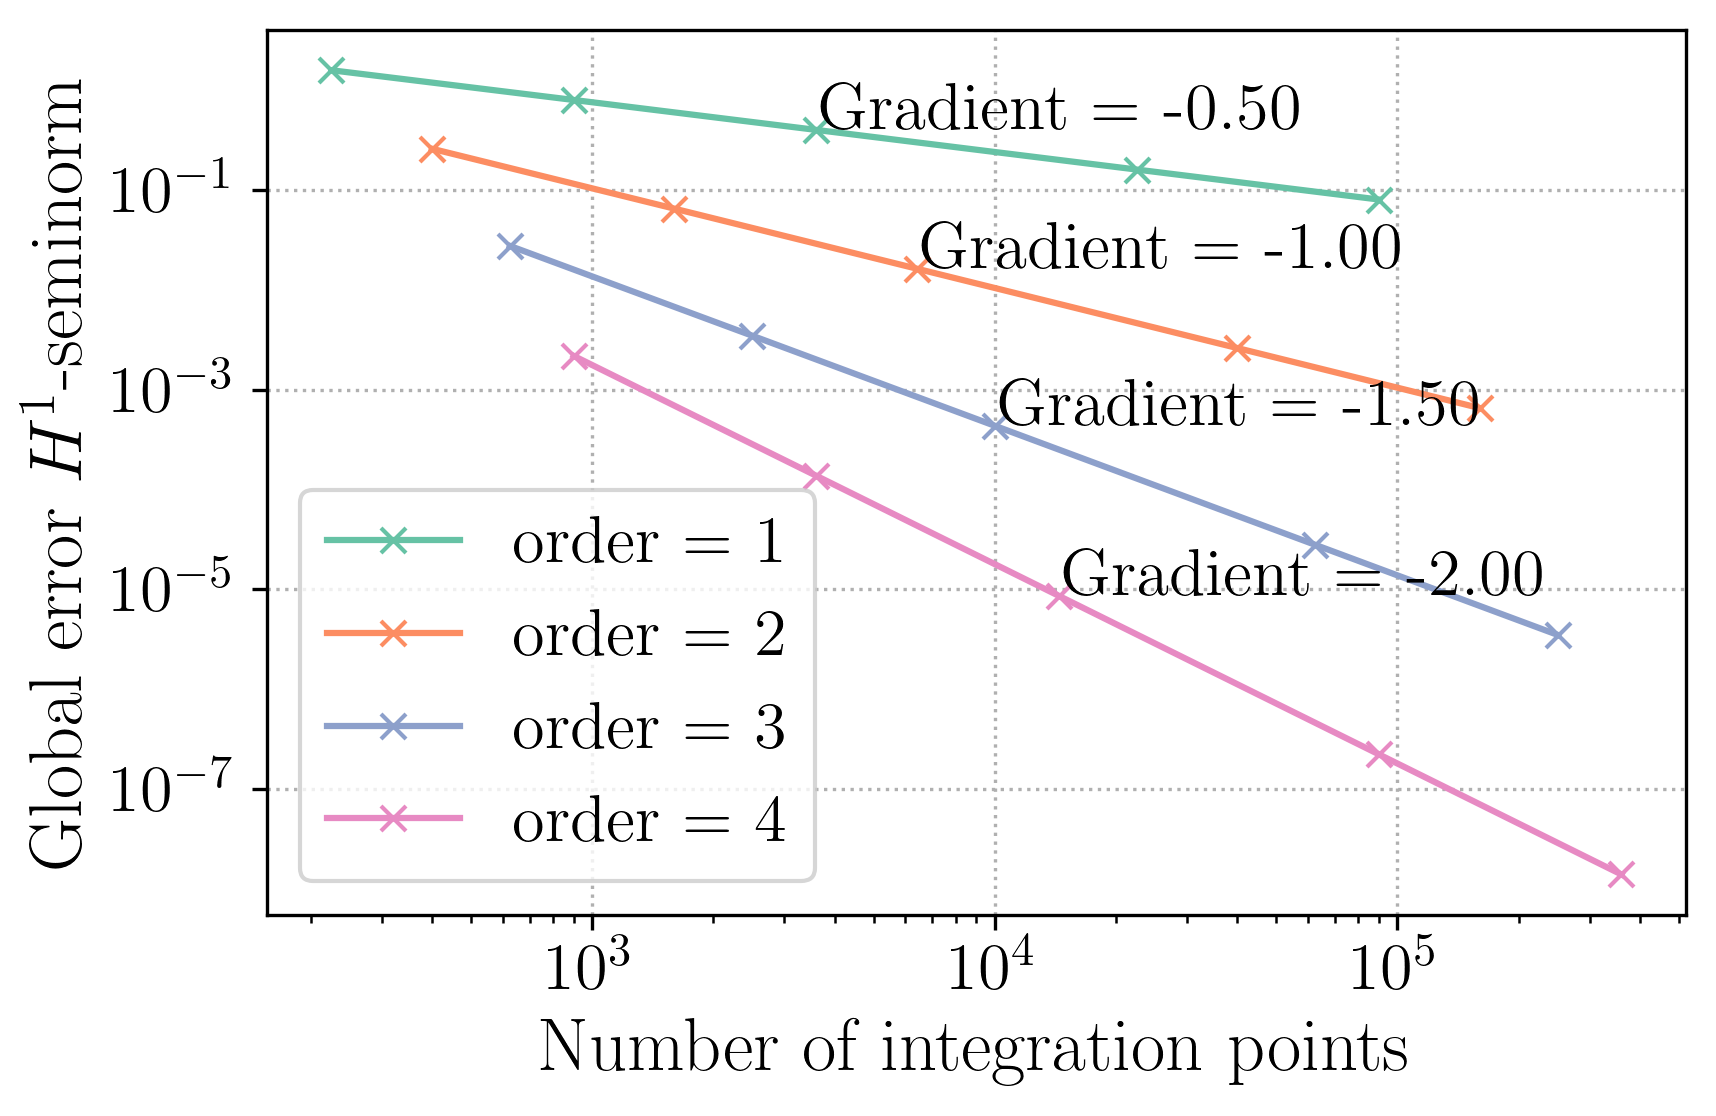

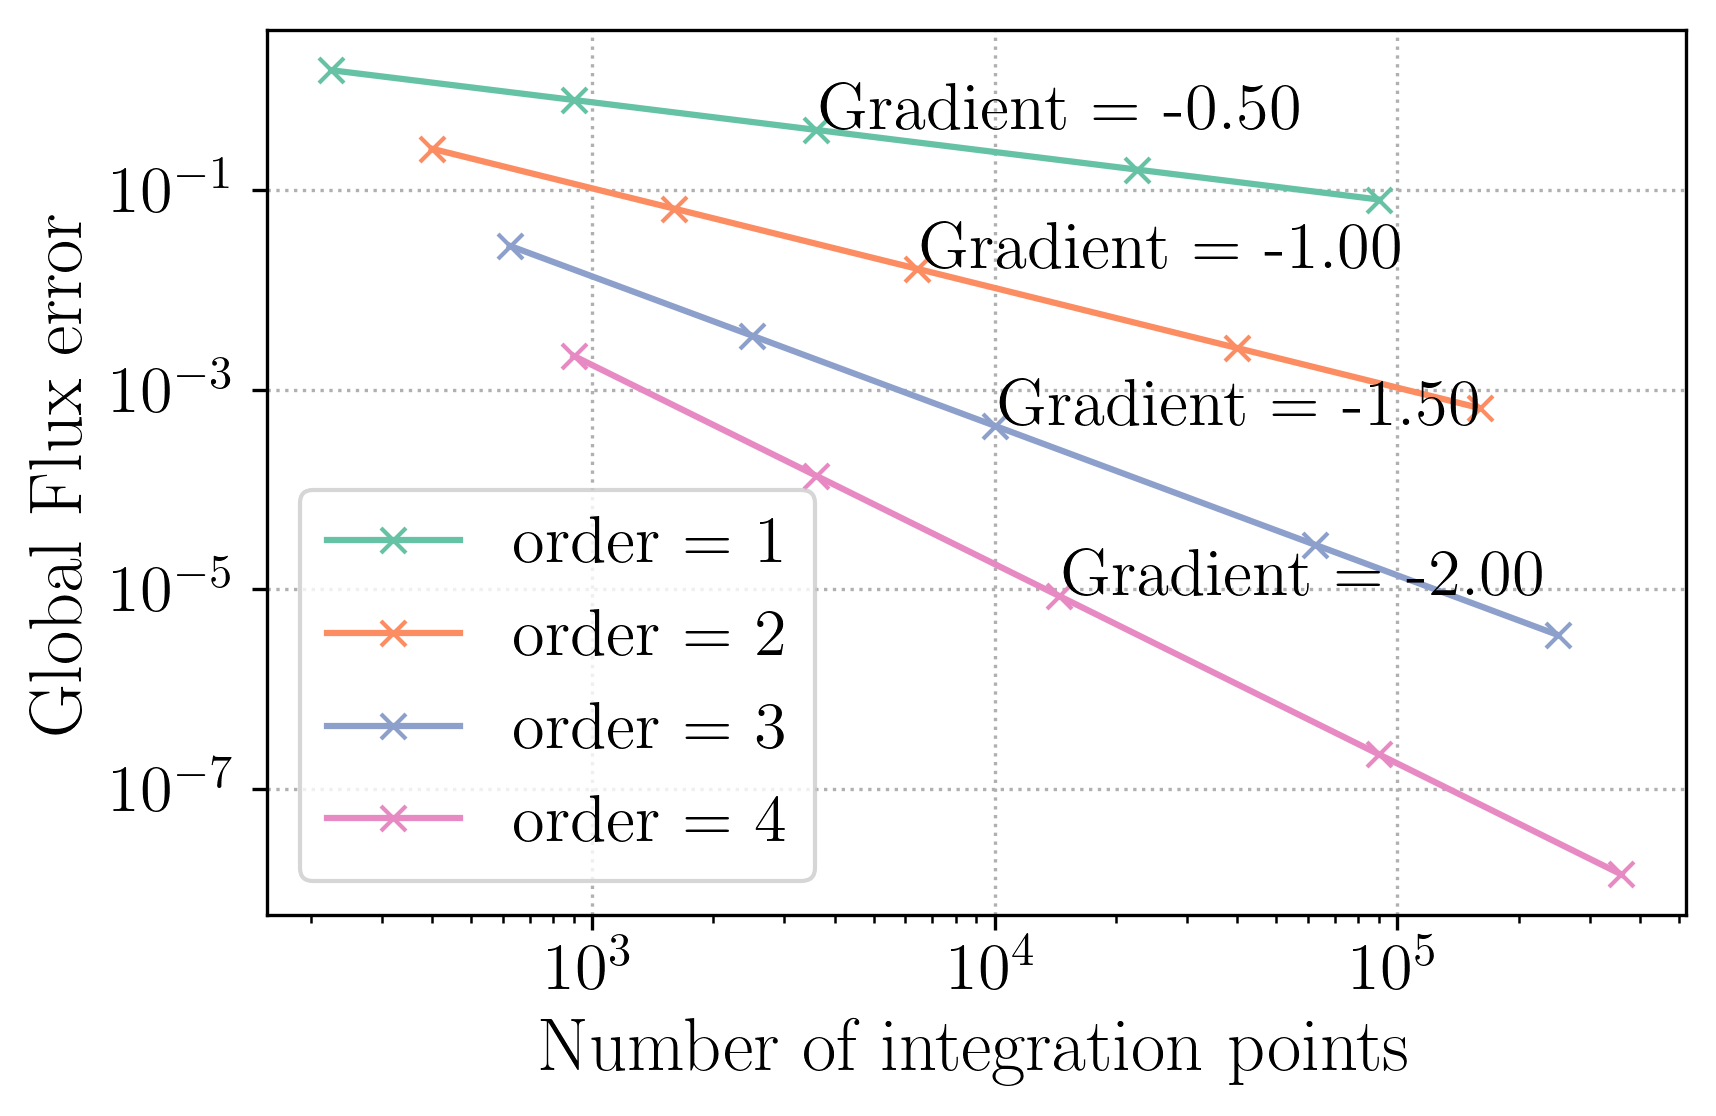

In [25]:
for (error_name, error_label) in zip(error_name_list,error_label_list):
    fig = plt.figure()
    ax = plt.axes()
    for i in range(len(order_list)):
        x = classic[i]["gaussnum"]
        y = classic[i][str(error_name)]

        line, = ax.plot(x, y, '-x', label=('order = ' + str(order_list[i])))

        # Calculate the gradient of the line
        gradient, _ = np.polyfit(np.log(x), np.log(y), 1)

        # Annotate the plot with the gradient value
        ax.annotate('Gradient = {:.2f}'.format(gradient), 
                    xy=(x.iloc[len(x)//2], y.iloc[len(y)//2]), 
                    xycoords='data',
                    xytext=(1, 0),  # move a bit to the right
                    textcoords='offset points'
                    )
        ax.set_xscale('log')
        ax.legend(loc='best')
        ax.set_yscale('log')
        ax.set_ylabel(error_label)
        ax.set_xlabel("Number of integration points")
        ax.grid(True, ls=':')

    plt.tight_layout()
    plt.savefig('c2_linear_gauss_' + error_name + '.svg')
    plt.savefig('c2_linear_gauss_' + error_name + '.png')
    plt.savefig('c2_linear_gauss_' + error_name + '.pdf')

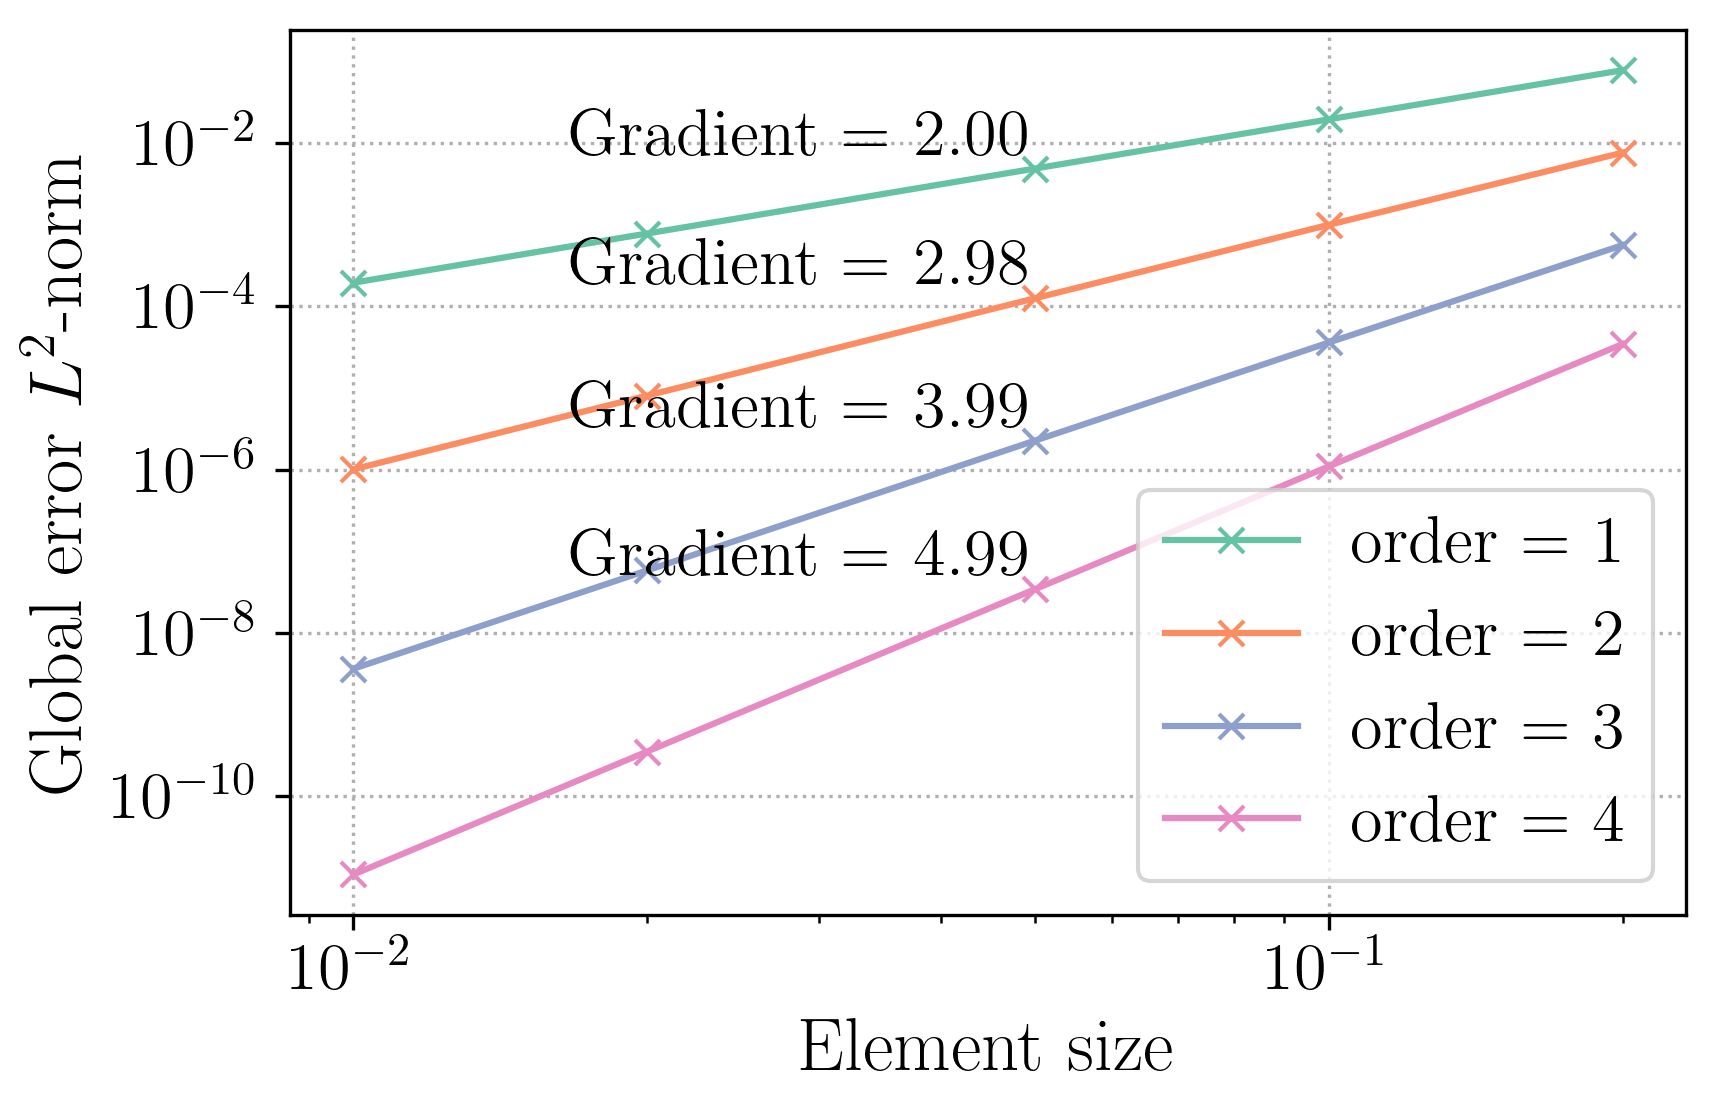

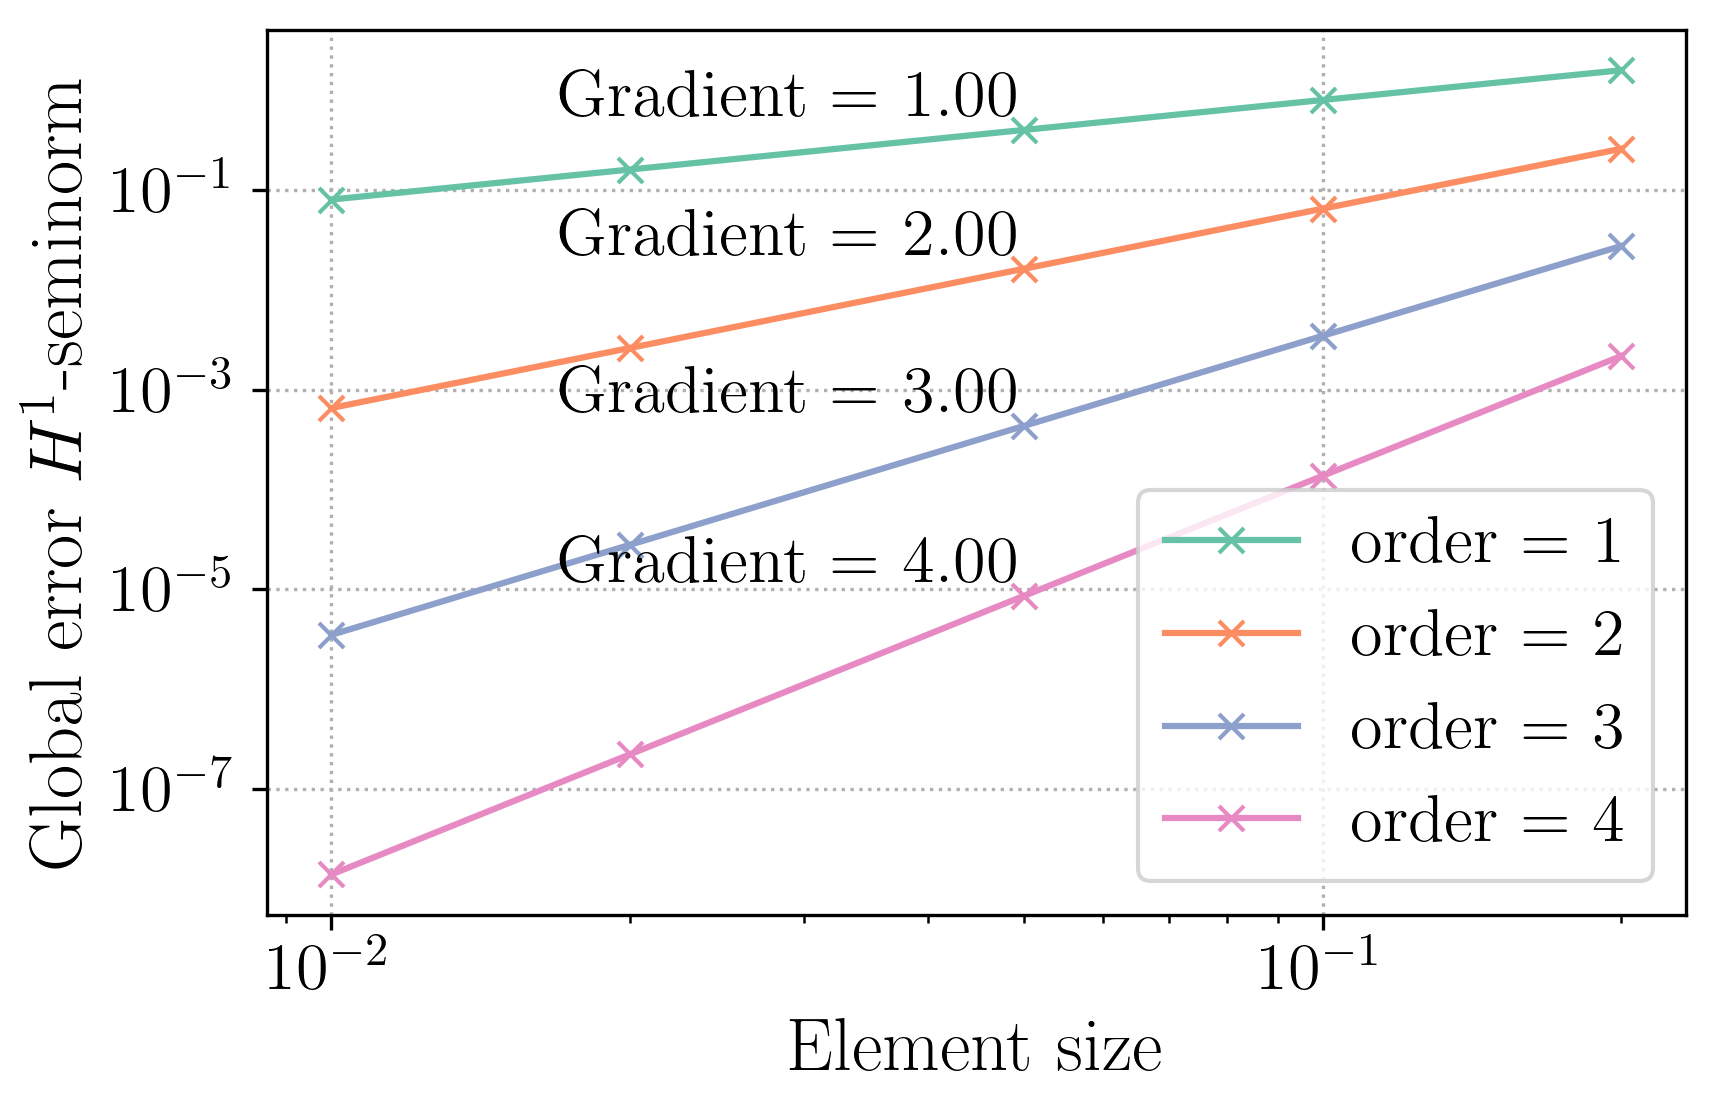

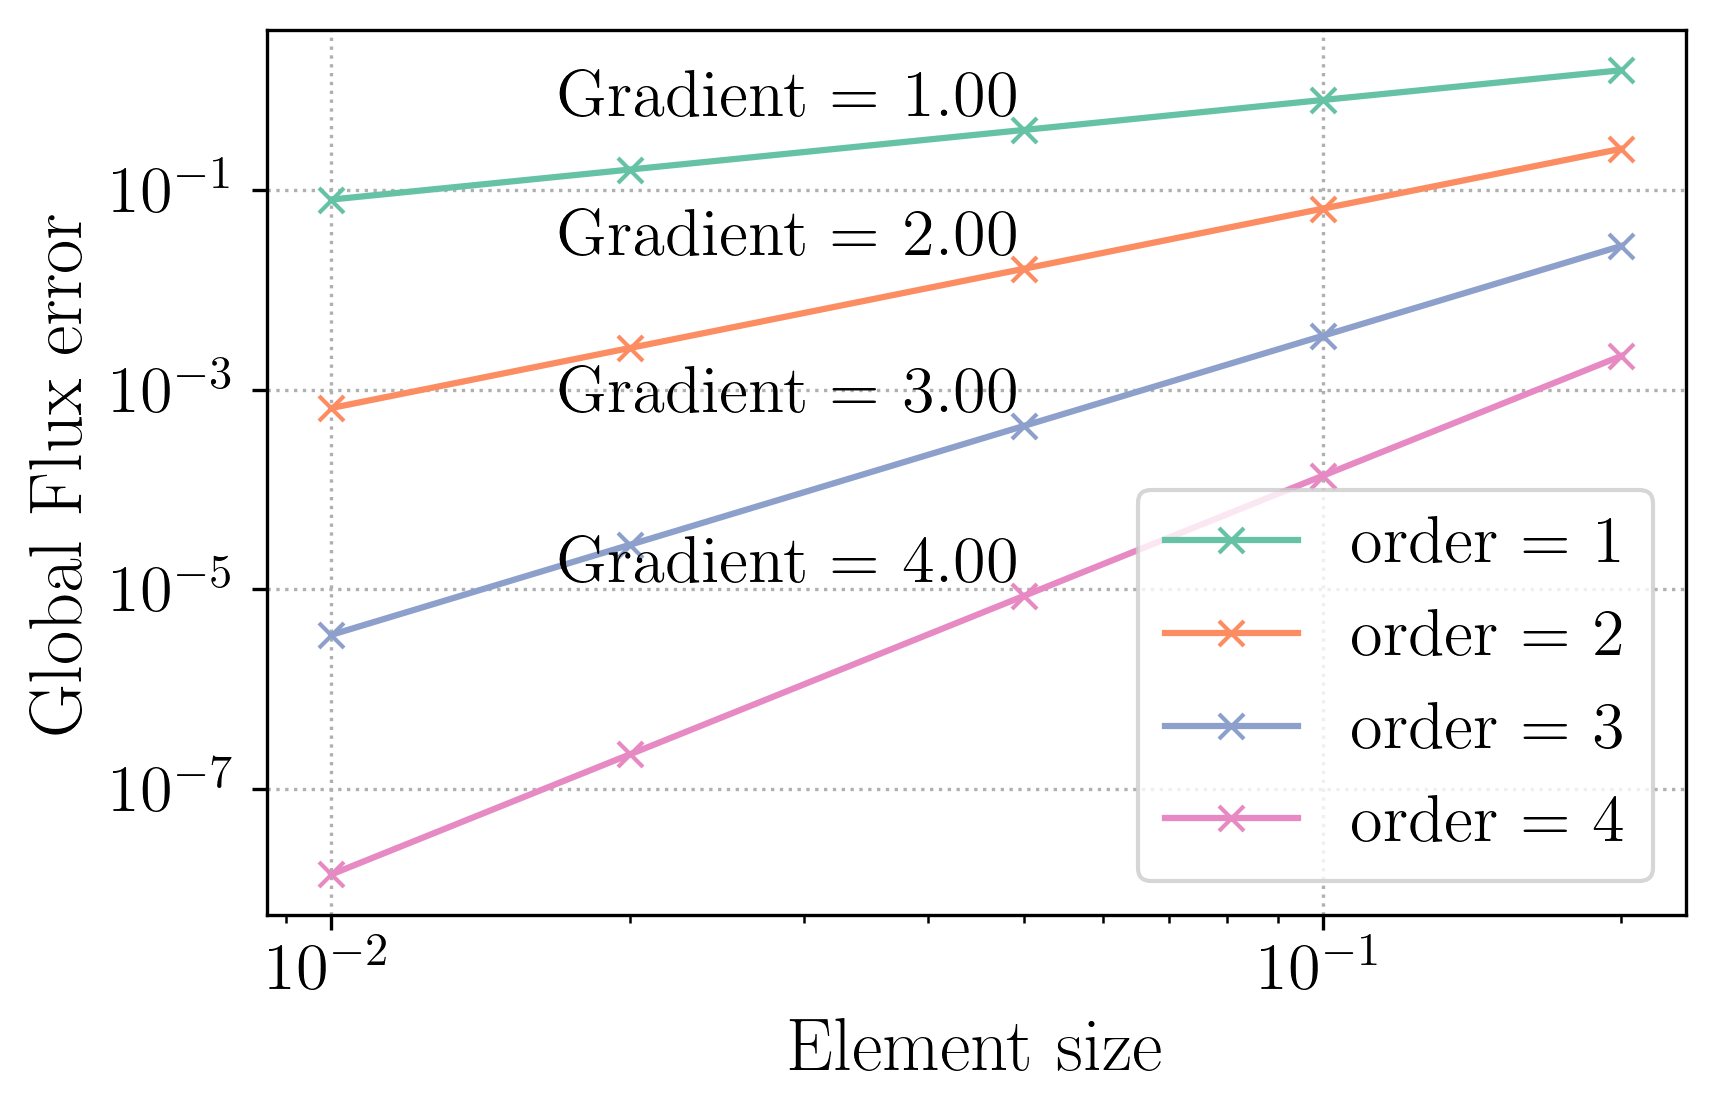

In [26]:
for (error_name, error_label) in zip(error_name_list,error_label_list):
    fig = plt.figure()
    ax = plt.axes()
    for i in range(len(order_list)):
        x = elem_size_list
        y = classic[i][str(error_name)]

        line, = ax.plot(x, y, '-x', label=('order = ' + str(order_list[i])))

        # Calculate the gradient of the line
        gradient, _ = np.polyfit(np.log(x), np.log(y), 1)

        # Annotate the plot with the gradient value
        ax.annotate('Gradient = {:.2f}'.format(gradient), 
                    xy=(x[len(x)//2], y.iloc[len(y)//2]), 
                    xycoords='data',
                    xytext=(-1, 0),  # move a bit to the left
                    textcoords='offset points',
                    ha='right',  # Horizontal alignment is right
                    va='bottom',  # Vertical alignment is bottom
                    )
        ax.set_xscale('log')
        ax.legend(loc='best')
        ax.set_yscale('log')
        ax.set_ylabel(error_label)
        ax.set_xlabel("Element size")
        ax.grid(True, ls=':')

    plt.tight_layout()
    plt.savefig('c2_linear_lenghtEle_' + error_name + '.svg')
    plt.savefig('c2_linear_lenghtEle_' + error_name + '.png')
    plt.savefig('c2_linear_lenghtEle_' + error_name + '.pdf')